# Clustering and Visualization of Phoebe dataset

## Components
* Create dataset with every row linked to the image it was generated from
    * Will need to extract images from videos like this:
    `ffmpeg -ss 00:23:00 -i video.mp4 -frames:v 1 out_time.jpg`


In [ ]:
%%capture
DATASET_FILE = "Phoebe_dataset4.zip"
!unzip $DATASET_FILE;

---
## Load datasets
### Helper functions

In [ ]:
import numpy as np
import os, os.path
from typing import List, Dict, Union
import csv
import uuid
import re
import time
import datetime
import logging

# Paths
PATH_DATASET = "Phoebe_dataset4"
PATH_AU_INTENSITY = "single_person_au_intensity"
PATH_AU_PRESENCE = "single_person_au_presence"
PATH_TRAIN = "train"
PATH_TEST = "test"
PATH_TRAINING_VIDEOS = PATH_DATASET + "/videos/train"
PATH_PROCESSED_IMAGES = PATH_DATASET + "/processed_images"
PATH_TRAINING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TRAIN}/"

# General
EXT_MP4 = "mp4"

# Stores
IMAGE_STORE = {}

log = logging.getLogger()
log.setLevel(logging.DEBUG)

In [157]:
def extract_image_for_timestamp(
        orig_filename: str, 
        timestamp_sec: float) -> str:
    """Extracts a frame from a video given a timestamp in seconds.
    
    :param orig_filename: name of video for which timestamp applies
    :param timestamp_sec: timestamp in seconds (e.g.: 1.3460006)
    
    :return: name of the image without its extension.
    """
    
    timestamp = datetime.timedelta(seconds=float(timestamp_sec.replace(" ", "")))
    img_name = f"{orig_filename}_{str(timestamp)}"
    img_file = f"{img_name}.jpg"
    img_filepath = os.path.abspath(f"{PATH_PROCESSED_IMAGES}/{img_file}")
    video_filepath = PATH_TRAINING_VIDEOS + "/" + f"{orig_filename}.{EXT_MP4}"
    
    # Generate image if it does not exist
    if not os.path.exists(img_filepath):
        command = f"ffmpeg -ss {str(timestamp)} -i {video_filepath} -frames:v 1 {img_filepath}"
        print(command)
        !$command;
    
    # Add to image store
    global IMAGE_STORE
    IMAGE_STORE[img_name] = img_filepath
    
    return img_name

    
def load_dataset(filename: str) -> List[Union[str, float]]:
    """Load dataset for a single csv/video pair.
    
    :param filename: name of video and csv without an extension.
    
    :return: result dataset for csv/video pair.
    """
    # Load csv with python library so that first column may be removed.
    raw_data = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        
        for index, row in enumerate(reader):
            new_row = row[1:]
            if index == 0:
                new_row.insert(0, "filename")
            elif new_row[0] != "":
                # Create an image for every row and add to dictionnary {id: path}
                filename_without_ext: str = re.sub("\D", "", filename)
                row_id = extract_image_for_timestamp(filename_without_ext, timestamp_sec=new_row[1])
                new_row.insert(0, row_id)
            raw_data.append(new_row)
    
    return raw_data

def create_full_dataset(training_files) -> List[Union[str, float]]:
    """Load dataset for every csv/video pair.
    
    :param training_files: list of csv files.
    
    :return: full dataset results
    """
    full_dataset = []
    for file in training_files:
        dataset = load_dataset(file)
        if len(full_dataset) == 0:
            full_dataset = dataset
        else:
            full_dataset.extend(dataset[1:])
    return full_dataset

In [166]:
from IPython.display import display, Image

def show_image(image_id: str):
    try:
        image = Image(filename=f'./{PATH_PROCESSED_IMAGES}/{image_id}.jpg')
        display(image)
    except IOError as e:
        print(e)
        

### Run dataset pipeline

In [154]:
%%capture
training_files: List[str] = [f"{PATH_TRAINING_CSV}/{name}" for 
                             name in os.listdir(f"{PATH_TRAINING_CSV}") if 
                             name[-4:] == ".csv"]

# Load datasets
full_dataset = create_full_dataset(training_files)

In [155]:
print(len(full_dataset))
print(full_dataset[0:5])

3569
[['filename', ' face_id', ' timestamp', ' confidence', ' success', ' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r', ' AU07_r', ' AU09_r', ' AU10_r', ' AU12_r', ' AU14_r', ' AU15_r', ' AU17_r', ' AU20_r', ' AU23_r', ' AU25_r', ' AU26_r', ' AU45_r'], ['6_0:00:00', '0', '0.0', '0.98', '1', '0.0', '0.0', '0.0', '0.0', '1.14', '2.01', '0.0', '1.65', '1.83', '0.29', '0.94', '0.81', '0.0', '0.2', '0.0', '0.16', '0.0'], ['6_0:00:00.040000', '0', '0.04', '0.93', '1', '0.0', '0.0', '0.0', '0.0', '0.98', '1.82', '0.0', '1.38', '1.67', '0.51', '0.45', '0.58', '0.0', '0.07', '0.13', '0.11', '0.0'], ['6_0:00:00.080000', '0', '0.08', '0.98', '1', '0.02', '0.05', '0.0', '0.0', '0.94', '1.74', '0.0', '1.2', '1.56', '0.54', '0.27', '0.5', '0.0', '0.0', '0.25', '0.06', '0.06'], ['6_0:00:00.120000', '0', '0.12', '0.98', '1', '0.02', '0.05', '0.0', '0.0', '0.99', '1.79', '0.0', '1.06', '1.5', '0.5', '0.27', '0.43', '0.0', '0.0', '0.34', '0.08', '0.06']]


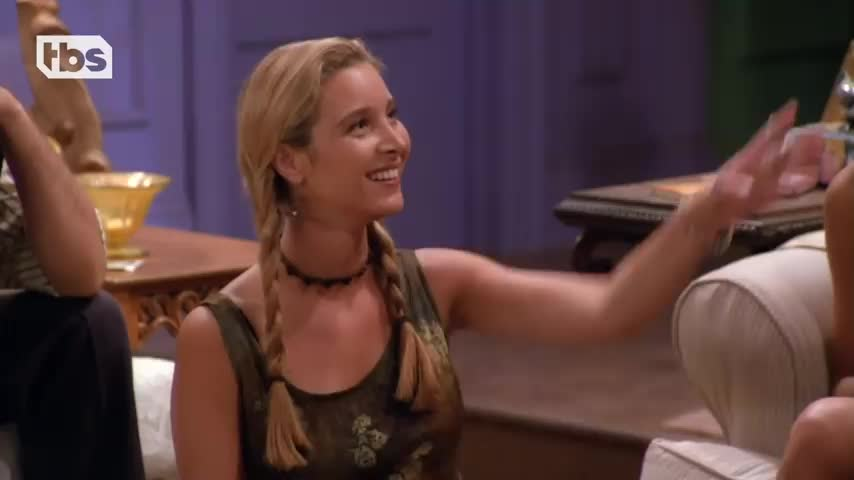

In [167]:
show_image(full_dataset[1][0])

## 1. Gausian Mixture Model

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.mixture import GMM



ImportError: cannot import name 'GMM' from 'sklearn.mixture' (/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/__init__.py)